In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import fftconvolve as fftconvolve
from scipy.signal import convolve as conv

In [2]:
# Setup constants
kb = 1.38065*10**-26
T = 400
Na = 6.022*10**23
Beta = 1/(Na*kb*T)
# print(Beta)

In [3]:
# Setup grids and so on....
pts = 120
# Hard wall at x = 10 & 110 => a system of length 100

# def v(x):
#     # Lennard-Jones
#     epsilon = 18
#     sigma = 27
#     cutoff = 10
#     if x<cutoff:
#         y = 100.0
#     else:
#         y = 4.0*epsilon*((sigma/x)**12-(sigma/x)**6)
#     return y

# # Vectorize allows analysis of function (v) at each point in an input array
# v = np.vectorize(v)
# v_ext = v(grid)

v_ext = np.zeros(pts)
v_ext[:10] = 100
v_ext[110:] = 100
# print(v_ext)

In [35]:
# define packing fraction and radius
# THis defines the system density etc...
packing_fraction = 0.5
radius = 5

# bulk density is determined from above
rho_bulk = packing_fraction / (2.0*radius)
# print('radius=', radius)
print('bulk rho=', rho_bulk)
# print('packing fraction=', packing_fraction)
rho = np.ones(pts)*rho_bulk

# Define vectors used for convolutions
surface_vector = np.zeros(2*radius+1)
surface_vector[0] = 0.5
surface_vector[-1] = 0.5
volume_vector = np.ones(2*radius+1)
# Half on edge vectors accounts for int between -R and +R
volume_vector[0] = 0.5
volume_vector[-1] = 0.5

# Hard rod contribution to the chemical potential
mu_ex = (1/Beta)*((packing_fraction/(1-packing_fraction)) - np.log(1-packing_fraction))
# print('mu_ex=', mu_ex)

# Hard contribution to the chemical potential via convolution 
rho = np.ones(pts)*rho_bulk

n0 = np.convolve(rho, surface_vector, mode='valid')
n1 = np.convolve(rho, volume_vector, mode='valid')
# print(n0,n1)

mu = np.convolve((n0/(1-n1)), volume_vector, mode='valid') - np.convolve(np.log(1-n1), surface_vector, mode='valid')
mu_conv = mu/Beta
# print(mu_conv[0])


bulk rho= 0.05


In [36]:
# function that convolves two vectors
def convolve(a, b):
    return np.convolve(a, b, mode='same')

In [37]:
# calculate c1
def calc_c1(rho):
    # calculate n0, n1
    n0 = convolve(rho, surface_vector) # *dx
    n1 = convolve(rho, volume_vector) # *dx
    c1 = convolve(np.log(1-n1), surface_vector) - convolve((n0/(1-n1)), volume_vector)
    
    return c1

In [38]:
def F_id(rho):
    return np.sum(rho*(np.log(rho)-1))/Beta

def F_hs(rho):
    n0 = convolve(rho, surface_vector) # *dx
    n1 = convolve(rho, volume_vector) # *dx
    np.clip(n1,-np.inf,0.99999999999999, out=n1)

    return -np.sum(n0*np.log(1-n1))/Beta

In [39]:
def mu_id(rho):
    return np.log(rho_bulk)/Beta

def mu_hs(rho):
    return mu_ex

In [40]:
def Omega(rho):
    F_tot = F_id(rho) + F_hs(rho)
    mu = mu_id(rho) + mu_hs(rho)

    return F_tot + np.sum(rho*(v_ext-mu))

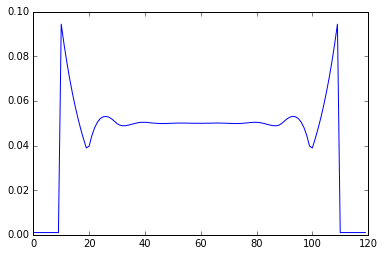

In [41]:
rho = np.ones(pts)*rho_bulk*np.exp(-Beta*v_ext)
res = minimize(Omega, rho, bounds=[(0.001,None)]*pts)

plt.plot(res.x, label='Density')

In [42]:
np.sum(rho)

5.000000000000087

In [110]:
# # PICARD ITERATION...
# # initial density is defined from the bulk density and external potential
# rho = np.ones(pts)*rho_bulk*np.exp(-Beta*v_ext)

# alpha = 0.002

# #Picard iteration here
# for i in range(1,10000):    

    
#     # calculate c(1)
#     c1 = calc_c1(rho)

#     # Update density
#     rho = ((1-alpha)*rho) + alpha*rho_bulk*np.exp((-Beta*v_ext)+c1+mu_ex)
